In [9]:
%%time
from td_toolkits_v3.opticals.tools.utils import OptLoader, OptFitting, RefOptLoader

target = 'LCT-15-1098'

test_loader = OptLoader(Experiment.objects.last().name)
rt_df = test_loader.rt
opt_df = test_loader.opt
target_rt_df = rt_df[rt_df['LC']==target]
target_opt_df = opt_df[opt_df['LC']==target]
test_fitting = OptFitting(target, target_rt_df, target_opt_df)

CPU times: user 143 ms, sys: 0 ns, total: 143 ms
Wall time: 143 ms


In [2]:
%time test_fitting.calc()
test_fitting.r2

CPU times: user 3.5 s, sys: 21.3 ms, total: 3.52 s
Wall time: 3.52 s


{'f(Tr, Cell Gap) |-> Vop': 0.9680318002363015,
 'f(Vop, Cell Gap) |-> RT': 0.8508059715880201,
 'f(Vop, Cell Gap) |-> Tr': 0.9434363334076885,
 'f(Vop, Cell Gap) |-> Tf': 0.2780704878368019,
 'f(Vop, Cell Gap) |-> Wx': 0.7248050003534448,
 'f(Vop, Cell Gap) |-> Wy': 0.6863482759072634,
 'f(Vop, Cell Gap) |-> WY': 0.8320077488944619,
 'f(Vop, Cell Gap) |-> LC%': 0.9622348315206666,
 'f(Vop, Cell Gap) |-> T%': 0.9941077847031449,
 'f(T%, Cell Gap) |-> Vop': 0.9512115041043419}

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

def aux_plot(x, y, model, labels, method='matplot'):
    """
    x: numpy.ndarray
        The input samples
    y: numpy.array
        The ouput
    model: sklearn model-ish object
        Should have predict method and fit the input x.
    labels: dict
        The plotting information
        {
            'title': '',
            'xlabel': '',
            'ylabel': '',
        }
    method: str, optional, default is 'matplot'
        The plotting method, 'matplot' and 'plotly' now.
        Using matplotlib or ploty to render.
    """
    
    # option gardian
    if method not in ['matplot', 'plotly']:
        print(f'The {method} is not implement now')
        return
    # sample
    # predict
    x0_range = np.linspace(min(x[:,0]), max(x[:,0]), 50)
    x1_range = np.linspace(min(x[:,1]), max(x[:,1]), 50)
    x0_range, x1_range = np.meshgrid(x0_range, x1_range)
    predict_region = np.array(
        list(zip(x0_range.flatten(), x1_range.flatten())))
    predict = model.predict(predict_region)
    if method == 'matplot':
        plt.figure(figsize=(10,8))
        ax = plt.axes(projection='3d')
        ax.scatter(x[:,0], x[:,1], y, label='sample')
        ax.scatter(
            x0_range, x1_range, predict, label='fitting surface', alpha=0.1)
        ax.set_title(labels['title'])
        ax.set_xlabel(labels['xlabel'])
        ax.set_ylabel(labels['ylabel'])
        ax.set_zlabel(labels['zlabel'])
        plt.legend()
        return ax
    elif method == 'plotly':
        df1 = pd.DataFrame({
            labels['xlabel']: x[:, 0],
            labels['ylabel']: x[:, 1],
            labels['zlabel']: y,
            'label': 'sample',
            'size': 2.5,
        })
        
        df2 = pd.DataFrame({
            labels['xlabel']: x0_range.flatten(),
            labels['ylabel']: x1_range.flatten(),
            labels['zlabel']: predict,
            'label': 'fitting surface',
            'size': 0.2,
        })
        
        df = pd.concat([df1, df2])
        
        fig = px.scatter_3d(
            df, 
            x=labels['xlabel'], y=labels['ylabel'], z=labels['zlabel'],
            color='label',
            size='size'
        )
        # tight layout
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        return fig
    

In [5]:
a = test_fitting.voltage_model
print(id(a))
print(id(test_fitting.voltage_model))
type(a)

140334677034800
140334677034800


sklearn.pipeline.Pipeline

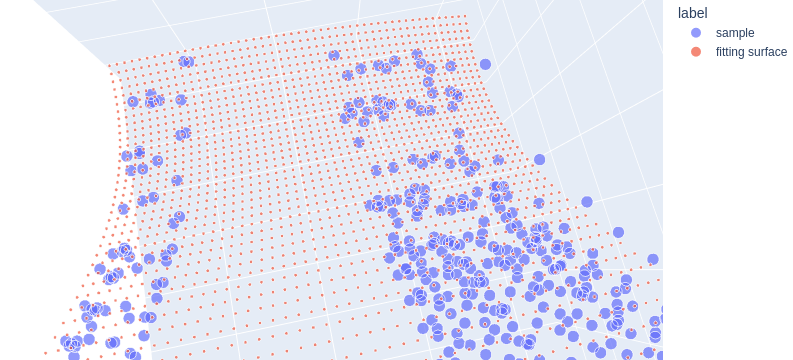

CPU times: user 515 ms, sys: 385 ms, total: 900 ms
Wall time: 162 ms


In [40]:
%%time
# 1. f(Tr, cell gap) |-> Vop
x = test_fitting.rt_df[['Tr', 'Cell Gap']].to_numpy()
y = test_fitting.rt_df['Vop'].to_numpy()

labels = {
    'title': f"$R^2 = {test_fitting.r2['f(Tr, Cell Gap) |-> Vop']:.2f}$",
    'xlabel': 'Tr',
    'ylabel': 'Cell Gap',
    'zlabel': 'Vop'
}
ax = aux_plot(x, y, test_fitting.voltage_model, labels, 'plotly')

ax.show()

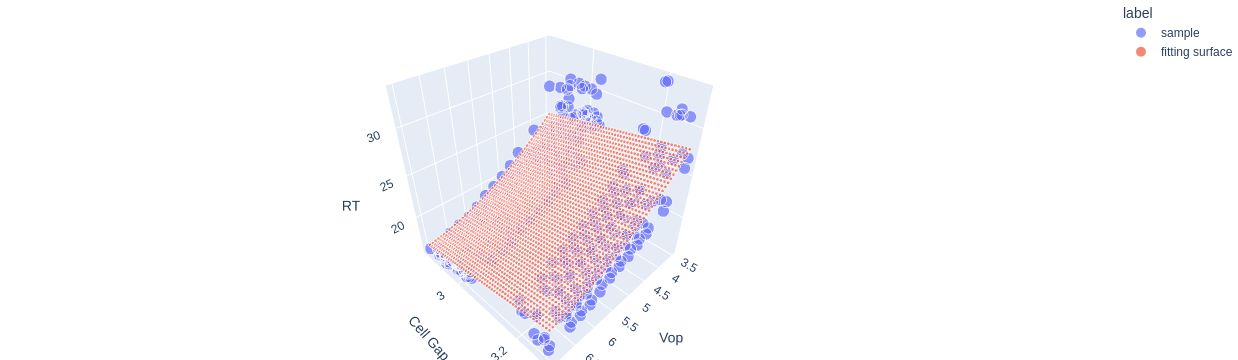

CPU times: user 572 ms, sys: 411 ms, total: 982 ms
Wall time: 175 ms


In [46]:
%%time
# 2. f(Vop, cell gap) |-> RT
x = test_fitting.rt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.rt_df['RT'].to_numpy()
labels = {
    'title': f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> RT']:.2f}$",
    'xlabel': 'Vop',
    'ylabel': 'Cell Gap',
    'zlabel': 'RT'
}
ax = aux_plot(x, y, test_fitting.response_time_model, labels,'plotly')

ax.show()

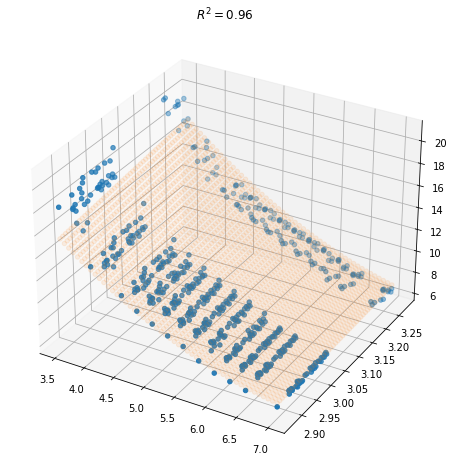

CPU times: user 986 ms, sys: 349 ms, total: 1.33 s
Wall time: 571 ms


In [37]:
%%time
# 3. f(Vop, cell gap) |-> Tr
x = test_fitting.rt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.rt_df['Tr'].to_numpy()

ax = aux_plot(x, y, test_fitting.time_rise_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> Tr']:.2f}$")
plt.show()

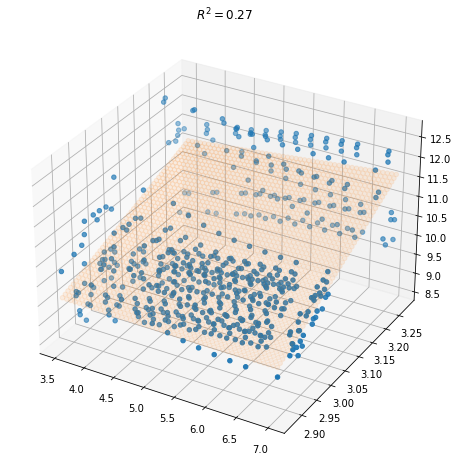

CPU times: user 1.05 s, sys: 305 ms, total: 1.35 s
Wall time: 590 ms


In [38]:
%%time
# 4. f(Vop, cell gap) |-> Tf
x = test_fitting.rt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.rt_df['Tf'].to_numpy()

ax = aux_plot(x, y, test_fitting.time_fall_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> Tf']:.2f}$")
plt.show()

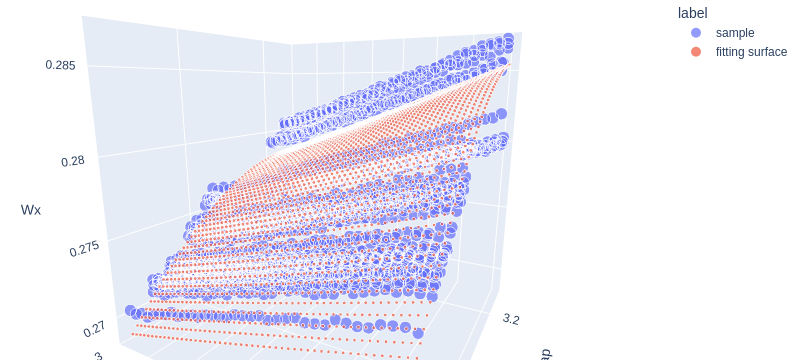

CPU times: user 507 ms, sys: 395 ms, total: 902 ms
Wall time: 210 ms


In [49]:
%%time
# 5. f(Vop, cell gap) |-> Wx
x = test_fitting.opt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['Wx'].to_numpy()
labels = {
    'title': f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> Wx']:.2f}$",
    'xlabel': 'Vop',
    'ylabel': 'Cell Gap',
    'zlabel': 'Wx'
}
ax = aux_plot(x, y, test_fitting.wx_model, labels, 'plotly')
ax.show()

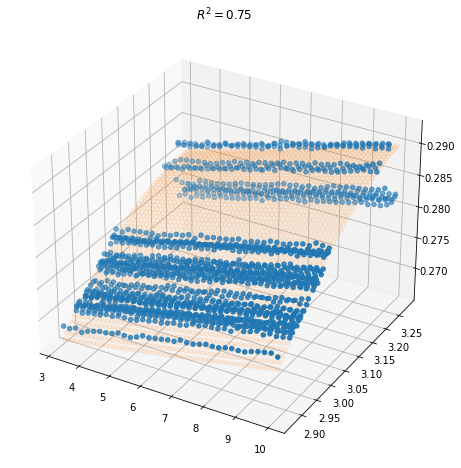

CPU times: user 1.16 s, sys: 352 ms, total: 1.51 s
Wall time: 706 ms


In [40]:
%%time
# 6. f(Vop, cell gap) |-> Wy
x = test_fitting.opt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['Wy'].to_numpy()

ax = aux_plot(x, y, test_fitting.wy_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> Wy']:.2f}$")
plt.show()

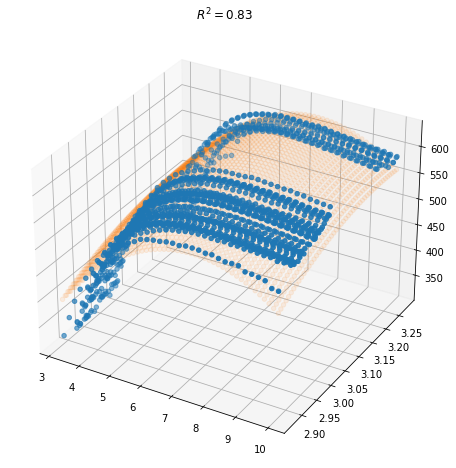

CPU times: user 1.4 s, sys: 395 ms, total: 1.79 s
Wall time: 834 ms


In [5]:
%%time
# 7. f(Vop, cell gap) |-> WY
x = test_fitting.opt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['WY'].to_numpy()

ax = aux_plot(x, y, test_fitting.w_capital_y_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> WY']:.2f}$")
plt.show()

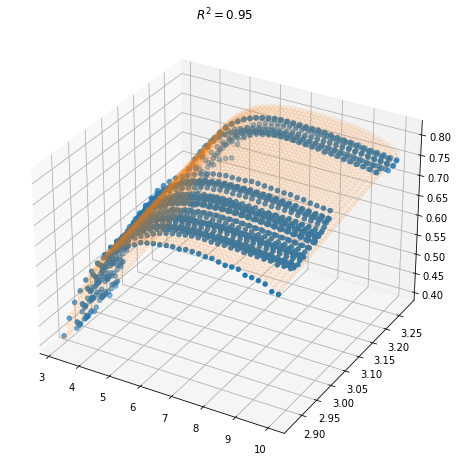

CPU times: user 1.43 s, sys: 381 ms, total: 1.81 s
Wall time: 871 ms


In [41]:
%%time
# 8. f(Vop, cell gap) |-> LC%
x = test_fitting.opt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['LC%'].to_numpy()

ax = aux_plot(x, y, test_fitting.lc_percent_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> LC%']:.2f}$")
plt.show()

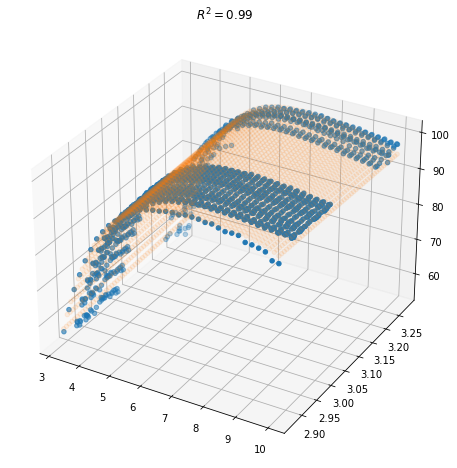

CPU times: user 594 ms, sys: 357 ms, total: 951 ms
Wall time: 281 ms


In [52]:
%%time
# 9. f(Vop, cell gap) |-> T%
x = test_fitting.opt_df[['Vop', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['T%'].to_numpy()

ax = aux_plot(x, y, test_fitting.transmittance_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(Vop, Cell Gap) |-> T%']:.2f}$")
plt.show()

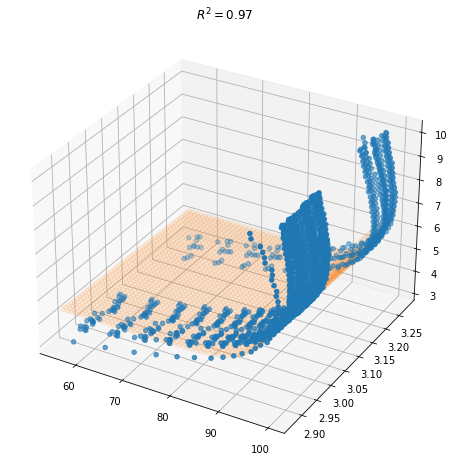

CPU times: user 529 ms, sys: 132 ms, total: 661 ms
Wall time: 382 ms


In [4]:
%%time
# 10. f(T%, cell gap) |-> Vop
x = test_fitting.opt_df[['T%', 'Cell Gap']].to_numpy()
y = test_fitting.opt_df['Vop'].to_numpy()

ax = aux_plot(x, y, test_fitting.v_percent_model)
ax.set_title(f"$R^2 = {test_fitting.r2['f(T%, Cell Gap) |-> Vop']:.2f}$")
plt.show()

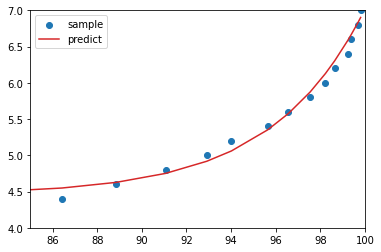

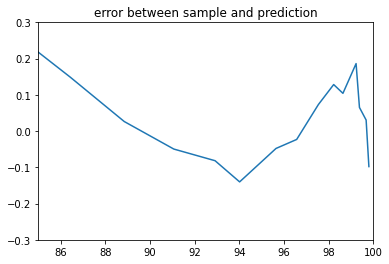

In [5]:
mask = x[:, 1]==3.002069
x_test = x[mask,:]
arg_max = x_test[:, 0].argmax()
x_test = x[:arg_max, :]
y_test = y[mask]
y_test = y[:arg_max]
plt.scatter(x_test[:, 0], y_test, label='sample')
y_predict = test_fitting.v_percent(x_test)
plt.plot(x_test[:, 0], y_predict,'tab:red', label='predict')
plt.legend()
plt.xlim(85, 100)
plt.ylim(4, 7)
plt.show()
plt.plot(x_test[:, 0], y_predict-y_test)
plt.title('error between sample and prediction')
plt.xlim(85, 100)
plt.ylim(-0.3, 0.3)
plt.show()

In [14]:
opt_df

ID           LC  Point   Vop       LC%      Wx      Wy  \
0      T19BU001NB0S  LCT-15-1098      1   0.0  0.001388  0.3183  0.3562   
1      T19BU001NB0S  LCT-15-1098      1   0.2  0.000835  0.2907  0.3603   
2      T19BU001NB0S  LCT-15-1098      1   0.4  0.001368  0.3131  0.3424   
3      T19BU001NB0S  LCT-15-1098      1   0.6  0.002159  0.3237  0.3566   
4      T19BU001NB0S  LCT-15-1098      1   0.8  0.002200  0.3038  0.3248   
...             ...          ...    ...   ...       ...     ...     ...   
14377  T19BR001NN2S   ZIX-7054XX      6   9.2  0.767025  0.2844  0.2881   
14378  T19BR001NN2S   ZIX-7054XX      6   9.4  0.763970  0.2849  0.2886   
14379  T19BR001NN2S   ZIX-7054XX      6   9.6  0.764715  0.2849  0.2893   
14380  T19BR001NN2S   ZIX-7054XX      6   9.8  0.761978  0.2850  0.2891   
14381  T19BR001NN2S   ZIX-7054XX      6  10.0  0.759113  0.2851  0.2891   

             WY  Cell Gap         T%  
0        1.0743  2.933733   0.191195  
1        0.6513  2.933733   0.115020  
2        1.0198  2.933733   0.188440  
3        1.6669  2.933733   0.297399  
4        1.6566  2.933733   0.303047  
...         ...       ...        ...  
14377  602.9470  2.942038  98.220563  
14378  600.5043  2.942038  97.829358  
14379  601.0742  2.942038  97.924758  
14380  598.9907  2.942038  97.574274  
14381  596.6833  2.942038  97.207400  

[14382 rows x 10 columns]

In [4]:
experiment = Experiment.objects.last()
lc = LiquidCrystal.objects.get(name='LCT-15-1098')

In [5]:
test_fitting.save(lc, experiment)

<OpticalsFittingModel: fitting model of LCT-15-1098 @ RD11001105>

In [10]:
models = OpticalsFittingModel.objects.last()
models.r2

dict

In [13]:
%time models.voltage.predict([[3,3]])

CPU times: user 713 µs, sys: 0 ns, total: 713 µs
Wall time: 700 µs


array([9.24811562])

In [59]:
for i in opt_df['LC'].unique():
    print(i)

LCT-15-1098
SLC19V33
SLC20V87
ILD-843001
ZIX-7054XX


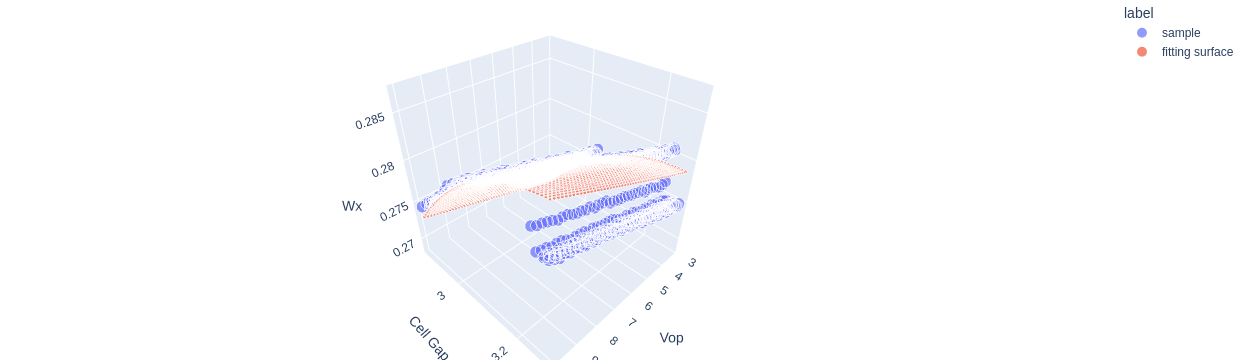

CPU times: user 609 ms, sys: 315 ms, total: 924 ms
Wall time: 207 ms


In [12]:
%%time
# 5. f(Vop, cell gap) |-> Wx
model = OpticalsFittingModel.objects.get(lc__name='LCT-15-1098')
opt_df = opt_df[(opt_df['Vop'] > 3) & (opt_df['LC'] == 'LCT-15-1098')]
x = opt_df[['Vop', 'Cell Gap']].to_numpy()
y = opt_df['Wx'].to_numpy()
labels = {
    'title': f"$R^2 = {model.r2['f(Vop, Cell Gap) |-> Wx']:.2f}$",
    'xlabel': 'Vop',
    'ylabel': 'Cell Gap',
    'zlabel': 'Wx'
}
ax = aux_plot(x, y, model.w_x, labels, 'plotly')
ax.show()

In [1]:
%%time
import pandas as pd
from td_toolkits_v3.opticals.tools.utils import RefOptLoader
ref = RefOptLoader(('T2', '6512')).ref
ref

CPU times: user 1.46 s, sys: 718 ms, total: 2.18 s
Wall time: 638 ms


Product Factory           LC  Cell Gap    T%      Tr     Tf    G2G      Wx  \
0    6512      T2  LCT-15-1098      3.12  99.0  15.072  6.318  15.57  0.2588   

        Wy      CR  
0  0.27273  1410.8

In [2]:
%%time
import numpy as np
import pandas as pd

from td_toolkits_v3.opticals.tools.utils import OptResultGenerator
test_gen = OptResultGenerator('LCT-15-1098', ('T2', '6512'))
test_gen.ref_data

CPU times: user 13.9 ms, sys: 64 µs, total: 13.9 ms
Wall time: 12.9 ms


{'Product': '6512',
 'Factory': 'T2',
 'LC': 'LCT-15-1098',
 'Cell Gap': 3.12,
 'T%': 99.0,
 'Tr': 15.072,
 'Tf': 6.318,
 'G2G': 15.57,
 'Wx': 0.2588,
 'Wy': 0.27273,
 'CR': 1410.8}

In [3]:
a = test_gen.table
a

LC       V90       V95       V99       Vop  Cell Gap   Δnd  \
1   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       2.5  0.25   
2   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       2.6  0.26   
3   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       2.7  0.27   
4   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       2.8  0.28   
5   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       2.9  0.29   
6   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       3.0  0.30   
7   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       3.1  0.31   
8   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       3.2  0.32   
9   LCT-15-1098  4.564328  5.104933  6.357286  3.912831       3.3  0.33   
10  LCT-15-1098  4.564328  5.104933  6.357286  3.912831       3.4  0.34   

           RT         Tr         Tf  ...        ΔL*      ΔEab*       Δu'  \
1   21.003647  12.429398   8.170035  ...  25.814735  25.931515  0.002883   
2   21.694281  12.800301   8.544655  ...  16.730386  17.115800  0.002394   
3   22.384914  13.171204   8.919275  ...  11.858488  13.112170  0.001964   
4   23.075547  13.542108   9.293895  ...   8.593033  10.465747  0.001579   
5   23.766181  13.913011   9.668514  ...   6.115445   8.249254  0.001229   
6   24.456814  14.283914  10.043134  ...   4.069210   6.169570  0.000906   
7   25.147448  14.654818  10.417754  ...   2.264080   4.143927  0.000601   
8   25.838081  15.025721  10.792374  ...   0.579637   2.237153  0.000308   
9   26.528715  15.396625  11.166994  ...  -1.075325   1.342818  0.000021   
10  27.219348  15.767528  11.541614  ...  -2.785428   2.837289 -0.000264   

         Δv'     Δu'v'         D          W           CR         ΔCR  \
1   0.013716  0.014016  0.018904  75.652996  1690.776574  279.976574   
2   0.011430  0.011678  0.019660  76.157468  1636.587559  225.787559   
3   0.009423  0.009625  0.020416  76.661939  1586.412546  175.612546   
4   0.007630  0.007792  0.021172  77.166411  1539.821462  129.021462   
5   0.006002  0.006127  0.021928  77.670882  1496.443557   85.643557   
6   0.004497  0.004588  0.022684  78.175354  1455.957512   45.157512   
7   0.003082  0.003140  0.023441  78.679826  1418.083470    7.283470   
8   0.001726  0.001753  0.024197  79.184297  1382.576555  -28.223445   
9   0.000403  0.000404  0.024953  79.688769  1349.221575  -61.578425   
10 -0.000911  0.000949  0.025709  80.193241  1317.828652  -92.971348   

           Remark  
1   Extrapolation  
2   Extrapolation  
3   Extrapolation  
4   Extrapolation  
5   Interpolation  
6   Interpolation  
7   Interpolation  
8   Interpolation  
9   Extrapolation  
10  Extrapolation  

[10 rows x 37 columns]

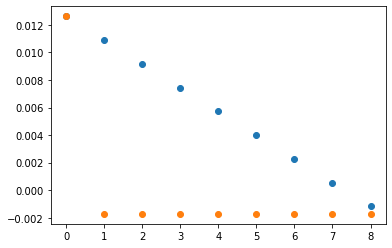

In [11]:
import matplotlib.pyplot as plt
w_y = test_gen.table['Wy'].to_numpy()
y = np.diff(w_y)
x = [x for x in range(len(y))]
plt.plot(x, y, 'o')
plt.plot(x, np.diff(y, prepend=0), 'o')

In [12]:
np.diff(y,prepend=1)**2

array([9.74906261e-01, 2.97743535e-06, 2.97743535e-06, 2.97743535e-06,
       2.97743535e-06, 2.97743535e-06, 2.97743535e-06, 2.97743535e-06,
       2.97743535e-06])

In [8]:
y

array([ 0.01262658,  0.01090106,  0.00917554,  0.00745001,  0.00572449,
        0.00399896,  0.00227344,  0.00054791, -0.00117761])

In [2]:
%time test_gen.vt_curve

CPU times: user 9.47 ms, sys: 0 ns, total: 9.47 ms
Wall time: 8.1 ms


LC  Cell Gap  Vop         T%
0    LCT-15-1098       2.5  3.0  48.976977
1    LCT-15-1098       2.5  3.1  52.666442
2    LCT-15-1098       2.5  3.2  56.143696
3    LCT-15-1098       2.5  3.3  59.417350
4    LCT-15-1098       2.5  3.4  62.495829
..           ...       ...  ...        ...
695  LCT-15-1098       3.4  9.5  96.834563
696  LCT-15-1098       3.4  9.6  96.494645
697  LCT-15-1098       3.4  9.7  96.120387
698  LCT-15-1098       3.4  9.8  95.708471
699  LCT-15-1098       3.4  9.9  95.255391

[700 rows x 4 columns]

In [15]:
np.sqrt(a['L*']**2 + a['a*']**2)

0    135.354245
1    151.679084
2    163.206956
3    171.549505
4    177.483006
5    181.425239
6    183.605826
7    184.137039
8    183.043071
9    180.266399
dtype: float64

In [23]:
np.linalg.norm([a['L*'],a['a*']], axis=0)

array([135.35424518, 151.67908366, 163.20695613, 171.54950485,
       177.4830057 , 181.42523877, 183.60582566, 184.13703946,
       183.04307136, 180.26639876])

In [18]:
np.array([a['L*'],a['a*']])

array([[133.47410335, 150.20448912, 162.06297741, 170.65601023,
        176.77145508, 180.84066487, 183.10474532, 183.68438206,
        182.60905725, 179.82362911],
       [ 22.481891  ,  21.09871716,  19.28994252,  17.4859597 ,
         15.8767119 ,  14.55236037,  13.55549536,  12.90337506,
         12.59754675,  12.62683394]])

In [14]:
import pandas as pd
[i[0] for i in OpticalsFittingModel.objects.all().values_list('lc__name').order_by('modified').distinct()]

['LCT-15-1098', 'SLC19V33', 'SLC20V87', 'ILD-843001', 'ZIX-7054XX']

In [4]:
header = {
    "ref_product__product_model_type__name": "Product",
    "ref_product__product_model_type__factory__name": "Factory",
    "ref_product__lc__name": "LC",
    "ref_product__cell_gap": "Cell Gap",
    'response_time': 'RT',
    "lc_percent": "LC%",
    'delta_e_ab':  'ΔEab*',
    'contrast_ratio': 'CR'          
}
profile_df = pd.DataFrame.from_records(
    OpticalSearchProfile.objects
    .filter(name='Default')
    .values(*header)
).rename(
    columns=header
)


In [5]:
profile_df.dtypes

Product      object
Factory      object
LC           object
Cell Gap    float64
RT          float64
LC%         float64
ΔEab*       float64
CR          float64
dtype: object

In [6]:
profile_df['Cell Gap']

0    3.12
Name: Cell Gap, dtype: float64